# 1. Environment Description

 A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

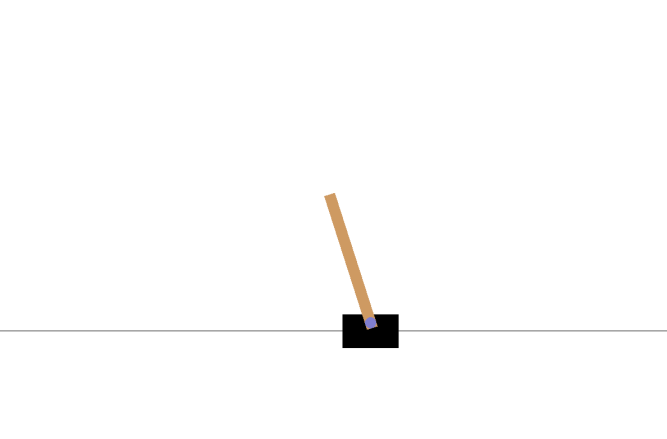

In [290]:
import gym
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import namedtuple

In [291]:
env_name = "CartPole-v0"
env = gym.make(env_name)

### 1-1. State

Cartpole environment consists of 4-dimensional state, with following components:

| Num |      Observation      |     Min    |    Max    |
|:---:|:---------------------:|:----------:|:---------:|
|  0  |     Cart Position     |    -4.8    |    4.8    |
|  1  |     Cart Velocity     |    -Inf    |    Inf    |
|  2  |       Pole Angle      | -0.418 rad | 0.418 rad |
|  3  | Pole Angular Velocity |    -Inf    |    Inf    |


In [292]:
env.observation_space

Box(4,)

### 1-2. Action

| Num |         Action         |
|:---:|:----------------------:|
|  0  |  Push cart to the left |
|  1  | Push cart to the right |

In [293]:
env.action_space

Discrete(2)

### 1-3. Rewards
Reward is 1 for every step taken, including the termination step

# 2. Replay Memory

A replay memory stores the transitions, $(s_t, a_t, r_t, s_{t+1}, terminal)$ that the agent observes, allowing to reuse this data later.

In [294]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Save Transitions"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# 3. Q-Network

The sample Q-network is composed of two linear layers, with $ReLU$ activation function

In [295]:
class QNetwork(nn.Module):

    def __init__(self, state_dim, action_dim, hidden_dim=32):
        super(QNetwork, self).__init__()
        self.lin1 = nn.Linear(state_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

In [296]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
QNet = QNetwork(state_dim, action_dim)

In [298]:
QNet(torch.Tensor(env.reset()))

tensor([0.1171, 0.1130], grad_fn=<AddBackward0>)

# 5. Build Agents

In [285]:
class DQNAgent(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNAgent, self).__init__()
        self.action_dim = action_dim # required when executing random action 
        
        self.QNet = QNetwork(state_dim, action_dim)
        self.target_Qnet = QNetwork(state_dim, action_dim)
        self.target_Qnet.load_state_dict(self.QNet.state_dict())
        
        self.optimizer = torch.optim.Adam(self.QNet.parameters(), lr=1e-3)

        self.memory = ReplayMemory(5000)
        
        # Hyperparameters
        self.gamma = 0.999
        self.epsilon = 0.99
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995
        
        self.batch_size = 50
        
        self.num_fit = 0
        

    def get_action(self, state):
        
        if np.random.rand() > self.epsilon:
            # exploitation
            qs = self.QNet(state)
            action = qs.argmax().item()
            
        else:
            # exploration
            action =  np.random.randint(self.action_dim)
            
            
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return action

    def push(self, state, action, reward, next_state, terminated):
        self.memory.push(state, action, reward, next_state, terminated)

    def fit(self):
        if len(self.memory) < self.batch_size:
            return 0
        
        self.num_fit += 1
        
        sample = self.memory.sample(self.batch_size)
        
        state = [i[0] for i in sample]
        action = [i[1] for i in sample]
        reward = [i[2] for i in sample]
        next_state = [i[3] for i in sample]
        terminal = [i[4] for i in sample]

        state = np.stack(state)
        state_batch = torch.Tensor(state) # shape = [batch size X state_dim]
        
        action = np.array(action)
        action_batch = torch.tensor(action, dtype=int).unsqueeze(-1)

        next_state = np.stack(next_state)
        next_state_batch = torch.Tensor(next_state)

        reward = np.array(reward)
        reward_batch = torch.tensor(reward, dtype=torch.float32).reshape(-1, 1)

        terminal = np.array(terminal).astype(int)
        terminal_batch = torch.tensor(terminal).reshape(-1, 1)
        
        qs = self.QNet(state_batch).gather(1, action_batch)
        
        with torch.no_grad():
            q_max, _ = self.target_Qnet(next_state_batch).max(dim=-1, keepdims=True)
            q_target = reward_batch + self.gamma * q_max * (1 - terminal_batch)
        
        
        # compute loss
        loss = F.smooth_l1_loss(qs, q_target)
        
        # optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        
        if self.num_fit % 100 == 0 :
            self.target_Qnet.load_state_dict(self.QNet.state_dict())       


        return loss.item()

# Training code

episode : 0, reward : 47.0
episode : 1, reward : 23.0
episode : 2, reward : 12.0
episode : 3, reward : 15.0
episode : 4, reward : 13.0
episode : 5, reward : 30.0
episode : 6, reward : 23.0
episode : 7, reward : 12.0
episode : 8, reward : 29.0
episode : 9, reward : 12.0
episode : 10, reward : 12.0
episode : 11, reward : 23.0
episode : 12, reward : 20.0
episode : 13, reward : 23.0
episode : 14, reward : 28.0
episode : 15, reward : 14.0
episode : 16, reward : 13.0
episode : 17, reward : 13.0
episode : 18, reward : 38.0
episode : 19, reward : 32.0
episode : 20, reward : 24.0
episode : 21, reward : 16.0
episode : 22, reward : 20.0
episode : 23, reward : 46.0
episode : 24, reward : 19.0
episode : 25, reward : 14.0
episode : 26, reward : 47.0
episode : 27, reward : 42.0
episode : 28, reward : 22.0
episode : 29, reward : 27.0
episode : 30, reward : 59.0
episode : 31, reward : 58.0
episode : 32, reward : 59.0
episode : 33, reward : 43.0
episode : 34, reward : 15.0
episode : 35, reward : 58.0
ep

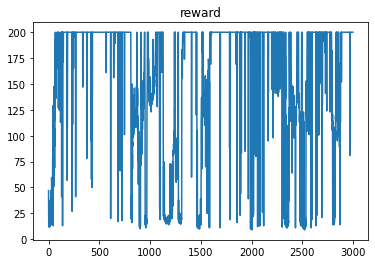

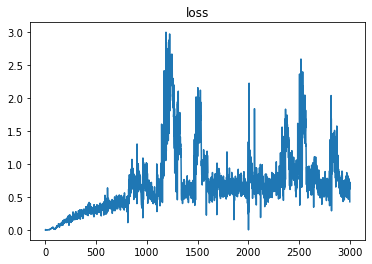

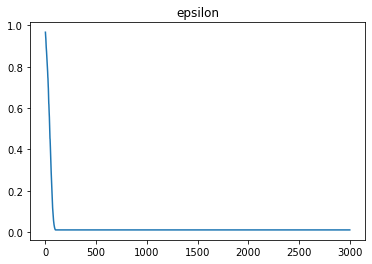

In [299]:
env_name = "CartPole-v0"
env = gym.make(env_name)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(state_dim, action_dim)

MAX_EPISODES = 3000

# Performance metric
rewards = []
loss_traj = []
epsilon_traj = []

for e in range(MAX_EPISODES):

    state = env.reset()
    
    episode_reward = 0
    episode_loss_sum = 0
    episode_len = 0

    while True:
        episode_len += 1

        state = torch.tensor(state, dtype=torch.float32)
        action = agent.get_action(state)

        next_state, reward, done, info = env.step(action)
        
        agent.push(state, action, reward/10, next_state, done) # save transition on every steps

        state = next_state
        
        loss = agent.fit()
        
        episode_reward += reward        
        episode_loss_sum += loss
            
        if done:
            rewards.append(episode_reward)
            loss_traj.append(episode_loss_sum/episode_len)
            epsilon_traj.append(agent.epsilon)
            
            print("episode : {}, reward : {}".format(e, episode_reward))
            break
        
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.title('reward')
plt.show()

plt.plot(loss_traj)
plt.title('loss')
plt.show()

plt.plot(epsilon_traj)
plt.title('epsilon')
plt.show()